# Translational invariance restoration
In this notebook we evaluate the solutions proposed by the literature, i.e., anti-aliasing and data augmentation, to restore translational invariance in CNNs in our use case of JPEG image analysis.  
We are then going to compare three variants of the various **DenseNets121**:
1. Standard network;
2. Anti-Aliasing (AA) full and pool only;
3. Training a standard network with random crop data-augmentation.


In [1]:
# Sys libraries
import os
import glob
import sys
sys.path.append('../')
from tqdm.notebook import tqdm

# Plotting libraries
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
# SETTING THE PLOT parameters to the ACM font
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Linux Libertine O'
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{libertine}'
]

%matplotlib inline

# Torch and data libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import SubsetRandomSampler, SequentialSampler, DataLoader
from isplutils.data import CustomBlockJPEGBalancedDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
from architectures import fornet
from architectures.fornet import create_model
import cv2

/tmp/ipykernel_2226082/2448125026.py:18: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [


## Helpers functions and classes

In [2]:
class TestJPEGBalancedDataset(CustomBlockJPEGBalancedDataset):
    
    # Override get_item
    def __getitem__(self, idx):
        # Select sample
        row = self.df.iloc[idx]
        # --- Load and transform uncompressed sample
        if self.grayscale:
            uncompressed = np.repeat(cv2.imread(os.path.join(self.data_root, row.name), cv2.IMREAD_GRAYSCALE)[:, :, np.newaxis], 3, axis=2).astype(np.float32)
        else:
            uncompressed = cv2.cvtColor(cv2.imread(os.path.join(self.data_root, row.name)), cv2.COLOR_BGR2RGB).astype(np.float32)
        # Crop
        if (self.disaligned_grid_patch[0] > 0) or (self.disaligned_grid_patch[1] > 0):
            if ((self.patch_size + self.disaligned_grid_patch[0] > uncompressed.shape[0]) or
                    (self.patch_size + self.disaligned_grid_patch[1] > uncompressed.shape[1])):
                mirrored = cv2.copyMakeBorder(uncompressed,
                                              0,
                                              np.abs(self.patch_size + self.disaligned_grid_patch[0] - uncompressed.shape[0]),
                                              0,
                                              np.abs(self.patch_size + self.disaligned_grid_patch[1] - uncompressed.shape[1]),
                                              cv2.BORDER_WRAP)
                mirrored = mirrored[self.disaligned_grid_patch[0]:self.disaligned_grid_patch[0]+self.patch_size,
                                    self.disaligned_grid_patch[1]:self.disaligned_grid_patch[1]+self.patch_size]
                uncompressed = self.transforms(image=mirrored)['image']
            else:
                uncompressed = self.transforms(image=uncompressed[self.disaligned_grid_patch[0]:self.disaligned_grid_patch[0]+self.patch_size,
                                                                  self.disaligned_grid_patch[1]:self.disaligned_grid_patch[1]+self.patch_size])['image']
        else:
            min_shape = np.min(uncompressed.shape)
            if self.patch_size > min_shape:
                mirrored = cv2.copyMakeBorder(uncompressed, 0, self.patch_size-min_shape, 0, self.patch_size-min_shape,
                                              cv2.BORDER_WRAP)
                mirrored = mirrored[:self.patch_size, :] if uncompressed.shape[0] > uncompressed.shape[1] \
                           else mirrored[:, :self.patch_size]
                uncompressed = self.transforms(image=mirrored)['image']
            else:
                uncompressed = self.transforms(image=uncompressed[0:self.patch_size, 0:self.patch_size])['image']

        # --- Load and transform compressed sample
        if self.grayscale:
            compressed = np.repeat(cv2.imread(os.path.join(self.data_root, row['jpeg_image_path']), 
                                              cv2.IMREAD_GRAYSCALE)[:, :, np.newaxis], 3, axis=2).astype(np.float32)
        else:
            compressed = cv2.cvtColor(cv2.imread(os.path.join(self.data_root, row['jpeg_image_path'])), cv2.COLOR_BGR2RGB).astype(np.float32)
        # Crop
        if (self.disaligned_grid_patch[0] > 0) or (self.disaligned_grid_patch[1] > 0):
            if ((self.patch_size + self.disaligned_grid_patch[0] > compressed.shape[0]) or
                    (self.patch_size + self.disaligned_grid_patch[1] > compressed.shape[1])):
                mirrored = cv2.copyMakeBorder(compressed,
                                              0,
                                              np.abs(self.patch_size + self.disaligned_grid_patch[0] - compressed.shape[0]),
                                              0,
                                              np.abs(self.patch_size + self.disaligned_grid_patch[1] - compressed.shape[1]),
                                              cv2.BORDER_WRAP)
                mirrored = mirrored[self.disaligned_grid_patch[0]:self.disaligned_grid_patch[0] + self.patch_size,
                           self.disaligned_grid_patch[1]:self.disaligned_grid_patch[1] + self.patch_size]
                compressed = self.transforms(image=mirrored)['image']
            else:
                compressed = self.transforms(image=compressed[self.disaligned_grid_patch[0]:self.disaligned_grid_patch[0]+self.patch_size,
                                                              self.disaligned_grid_patch[1]:self.disaligned_grid_patch[1]+self.patch_size])['image']
        else:
            min_shape = np.min(compressed.shape)
            if self.patch_size > min_shape:
                mirrored = cv2.copyMakeBorder(compressed, 0, self.patch_size - min_shape, 0,
                                              self.patch_size - min_shape,
                                              cv2.BORDER_WRAP)
                mirrored = mirrored[:self.patch_size, :] if compressed.shape[0] > compressed.shape[1] \
                    else mirrored[:, :self.patch_size]
                compressed = self.transforms(image=mirrored)['image']
            else:
                compressed = self.transforms(image=compressed[0:self.patch_size, 0:self.patch_size])['image']
        # Patch together the samples
        sample = torch.cat((uncompressed.unsqueeze(0), compressed.unsqueeze(0)))
        target = torch.Tensor((0, 1))
        return sample, target


def bin_acc(y_pred, y_test) -> float:
    y_pred_sig = torch.sigmoid(y_pred)
    y_pred_tags = y_pred_sig > 0.5
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc *= 100
    return acc


def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.nn.functional.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc) * 100
    return acc


def batch_forward(net: torch.nn.Module, device, criterion,
                  data: torch.Tensor, labels: torch.Tensor) -> (torch.Tensor, float):
    if torch.cuda.is_available():
        data = data.to(device)
        labels = labels.to(device)
    out = net(data).squeeze()
    loss = criterion(out, labels)
    pred = torch.sigmoid(out)
    return loss, pred


def balanced_collate_fn(batch):
    return [torch.cat([elem[0] for elem in batch]), torch.cat([elem[1] for elem in batch])]


## Execution parameters

In [3]:
models_dir = '../models/DenseNets'
gpu_id = 2
precomputed = True  # whether to use the precomputed results or let the notebook do the job
data_root = '../data'  # PLACE HERE THE DIRECTORY WHERE YOU SAVED THE DATASETS!

## Let's start
We are gonna cycle over all models and compute the test results first.  
We are going to find the correctly classified samples, and then meausure the deviation of the performances as a function of the diagonal displacement.

In [4]:
# Let's find all models available first
models_paths = glob.glob(os.path.join(models_dir, '**/bestval.pth'))

In [6]:
all_models_df = []

if os.path.exists('DenseNet121_disalignment_results.pkl') and precomputed:
    print('Results already computed! Loading them...')
    all_models_df = pd.read_pickle('DenseNet121_disalignment_results.pkl')
else:
    for model_path in models_paths:

        test_dfs = dict()
        
        # Parse useful params from the model path
        split_seed = int(model_path.split('split_seed-')[1].split('_')[0])
        p_train_test = float(model_path.split('train_test-')[1].split('_')[0])
        p_train_val = float(model_path.split('train_val-')[1].split('_')[0])
        net_name = model_path.split('net-')[1].split('_')[0]
        batch_size = 1
        if 'aa_pool_only' in model_path:
            aa_pool_only = model_path.split('aa_pool_only-')[1].split('/')[0] == 'True'
        else:
            aa_pool_only = None
        grayscale = True
        patch_size = 224

        # Set the device
        device = f'cuda:{gpu_id}' if torch.cuda.is_available() else 'cpu'
        params = {'in_channels': 3, 'num_classes': 1, 'pretrained': False,
                  'pool_only': aa_pool_only}
        # Create the model
        net = create_model(net_name, params, device).eval()

        # load model
        print(f'Loading model {model_path}...')
        state_tmp = torch.load(model_path, map_location='cpu')
        if 'net' not in state_tmp.keys():
            state = OrderedDict({'net': OrderedDict()})
            [state['net'].update({'model.{}'.format(k): v}) for k, v in state_tmp.items()]
        else:
            state = state_tmp
        incomp_keys = net.load_state_dict(state['net'], strict=True)
        print(incomp_keys)
        print('Model loaded!')

        test_dfs = []
        for disp in range(9):

            # Load the data
            net_normalizer = net.get_normalizer()
            transforms = [A.Normalize(mean=net_normalizer.mean, std=net_normalizer.std), ToTensorV2()]
            transforms = A.Compose(transforms)
            dataset = TestJPEGBalancedDataset(data_root=data_root, jpeg_bs=8, patch_size=patch_size, transforms=transforms,
                                              grayscale=grayscale, disaligned_grid_patch=[disp, disp])
            
            # Split in training, validation and test
            dataset_idxs = list(range(len(dataset)))
            np.random.seed(split_seed)  # setting the seed for training-test split
            np.random.shuffle(dataset_idxs)
            test_split_index = int(np.floor((1 - p_train_test) * len(dataset)))
            train_val_idxs, test_idxs = dataset_idxs[test_split_index:], dataset_idxs[:test_split_index]
            val_split_index = int(np.floor((1 - p_train_val) * len(train_val_idxs)))
            train_idx, val_idx = train_val_idxs[val_split_index:], train_val_idxs[:val_split_index]
            
            # Consider only the test samples indexes
            test_idxs = np.array(test_idxs)
            test_sampler = SequentialSampler(test_idxs)
            test_dl = DataLoader(dataset=dataset, batch_size=batch_size, num_workers=4, shuffle=False, drop_last=False,
                                   sampler=test_sampler, collate_fn=balanced_collate_fn,)

            # --- TEST LOOP
            test_df = pd.DataFrame(index=np.arange(len(test_idxs)*2))
            test_df['bce_loss'] = 0.0
            test_df['pred'] = 0.0
            test_df['labels'] = False
            criterion = torch.nn.BCEWithLogitsLoss()
            test_loss = test_acc = test_num = 0
            for idx, batch_data in enumerate(tqdm(test_dl, desc='Test sample', leave=False, total=len(test_dl))):
                
                # Fetch data
                batch_img, batch_label = batch_data

                with torch.no_grad():
                    # Forward pass
                    batch_loss, batch_pred = batch_forward(net, device, criterion, batch_img, batch_label)

                # Save statistics
                test_df.loc[idx*2, 'bce_loss'] = batch_loss.detach().cpu().item()
                test_df.loc[idx*2, 'labels'] = batch_label[0].detach().cpu().item()>0
                test_df.loc[idx*2, 'pred'] = batch_pred[0].detach().cpu().item()
                test_df.loc[idx*2+1, 'bce_loss'] = batch_loss.detach().cpu().item()
                test_df.loc[idx*2+1, 'labels'] = batch_label[1].detach().cpu().item()>0
                test_df.loc[idx*2+1, 'pred'] = batch_pred[1].detach().cpu().item()


            # Save the results in the bigger dictionary
            test_dfs.append(pd.concat({disp: test_df.copy()}, names=['Grid displacement']))

        # Concatenate everything
        all_models_df.append(pd.concat({model_path: pd.concat(test_dfs)}, names=['Model']))

    # Concatenate everything
    all_models_df = pd.concat(all_models_df)
    
    # Clean GPU memory
    torch.cuda.empty_cache()

all_models_df

/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading model ../models/DenseNets/net-DenseNet121_lr-0.001_batch_size-2_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-8_grayscale-True_random_crop-False/bestval.pth...
<All keys matched successfully>
Model loaded!


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/nas/home/ecannas/miniconda3/envs/jpeg_expl/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading model ../models/DenseNets/net-DenseNet121_lr-0.001_batch_size-2_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-8_grayscale-True_random_crop-True/bestval.pth...
<All keys matched successfully>
Model loaded!


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/DenseNets/net-AADenseNet121_lr-0.001_batch_size-2_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-8_grayscale-True_random_crop-False_aa_pool_only-False/bestval.pth...
<All keys matched successfully>
Model loaded!


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Loading model ../models/DenseNets/net-AADenseNet121_lr-0.001_batch_size-2_split_train_test-0.75_split_train_val-0.75_split_seed-42_in_channels-1_init_period-10_jpeg_bs-8_grayscale-True_random_crop-False_aa_pool_only-True/bestval.pth...
<All keys matched successfully>
Model loaded!


Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

Test sample:   0%|          | 0/334 [00:00<?, ?it/s]

bce_loss  \
Model                                              Grid displacement                 
../models/DenseNets/net-DenseNet121_lr-0.001_ba... 0                 0    0.000067   
                                                                     1    0.000067   
                                                                     2    0.000015   
                                                                     3    0.000015   
                                                                     4    0.000139   
...                                                                            ...   
../models/DenseNets/net-AADenseNet121_lr-0.001_... 8                 663  0.000260   
                                                                     664  0.002936   
                                                                     665  0.002936   
                                                                     666  0.180282   
                                                                     667  0.180282   

                                                                                  pred  \
Model                                              Grid displacement                     
../models/DenseNets/net-DenseNet121_lr-0.001_ba... 0                 0    7.916077e-05   
                                                                     1    9.999459e-01   
                                                                     2    5.623671e-07   
                                                                     3    9.999696e-01   
                                                                     4    1.339005e-04   
...                                                                                ...   
../models/DenseNets/net-AADenseNet121_lr-0.001_... 8                 663  9.995613e-01   
                                                                     664  1.113928e-03   
                                                                     665  9.952531e-01   
                                                                     666  3.027057e-01   
                                                                     667  9.999828e-01   

                                                                          labels  
Model                                              Grid displacement              
../models/DenseNets/net-DenseNet121_lr-0.001_ba... 0                 0     False  
                                                                     1      True  
                                                                     2     False  
                                                                     3      True  
                                                                     4     False  
...                                                                          ...  
../models/DenseNets/net-AADenseNet121_lr-0.001_... 8                 663    True  
                                                                     664   False  
                                                                     665    True  
                                                                     666   False  
                                                                     667    True  

[24048 rows x 3 columns]

### Let's save the results for precomputation

In [7]:
if os.path.exists('DenseNet121_disalignment_results.pkl'):
    print('Results already saved!')
else:
    all_models_df.to_pickle('DenseNet121_disalignment_results.pkl')

## Let's plot the paper's plots

### Absolute Score Difference (ASD)

/tmp/ipykernel_2226082/259710620.py:23: PerformanceWarning: indexing past lexsort depth may impact performance.
  pred_df = all_models_df.loc[(model_path), 'pred']


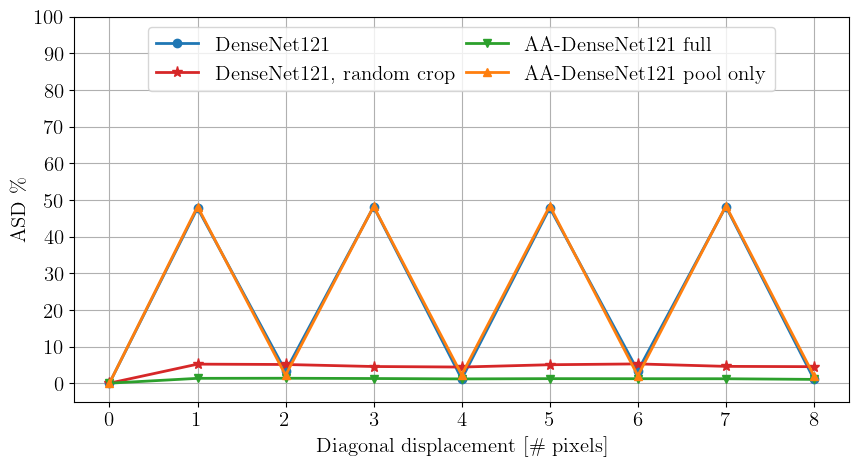

In [8]:
# Prepare plot
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
fontsize=20
markers = ['o', '*', 'v', '^']
color_map = {'DenseNet121': '#1f77b4', 'AA-DenseNet121 pool only': '#ff7f0e', 
              'AA-DenseNet121': '#2ca02c', 'DenseNet121 random crop': '#d62728'}
for idx, model_path in enumerate(models_paths):
    net_name = model_path.split('net-')[1].split('_')[0]
    random_crop = model_path.split('random_crop-')[1].split('/')[0] == 'True'
    if net_name == 'AADenseNet121':
        aa_pool = model_path.split('aa_pool_only-')[1].split('/')[0] == 'True'
        color = color_map['AA-DenseNet121 pool only'] if aa_pool else color_map['AA-DenseNet121']
    if 'AA' in net_name:
        if aa_pool:
            label = f'AA-DenseNet121 pool only'
        else:
            label = f'AA-DenseNet121 full'
    else:
        label = f'{net_name}'
        if random_crop:
            label += ', random crop'
        color = color_map['DenseNet121 random crop'] if random_crop else color_map['DenseNet121']
    pred_df = all_models_df.loc[(model_path), 'pred']
    differences = []
    for disp in range(9):
        differences.append(np.mean(np.abs(pred_df.loc[disp].to_numpy() - pred_df.loc[0].to_numpy()))*100)
    axs.plot(differences, label=label, marker=markers[idx], markersize=8 if markers[idx]=='*' else 6, 
             linewidth=2, color=color)
axs.legend(fontsize=fontsize-5, ncol=2, columnspacing=0.5, loc='upper center')
axs.set_ylabel(r'ASD \%', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-5, 100])
axs.set_yticks(np.arange(0, 110, 10))
axs.set_xticks(np.arange(9))
plt.show()

### BCE loss

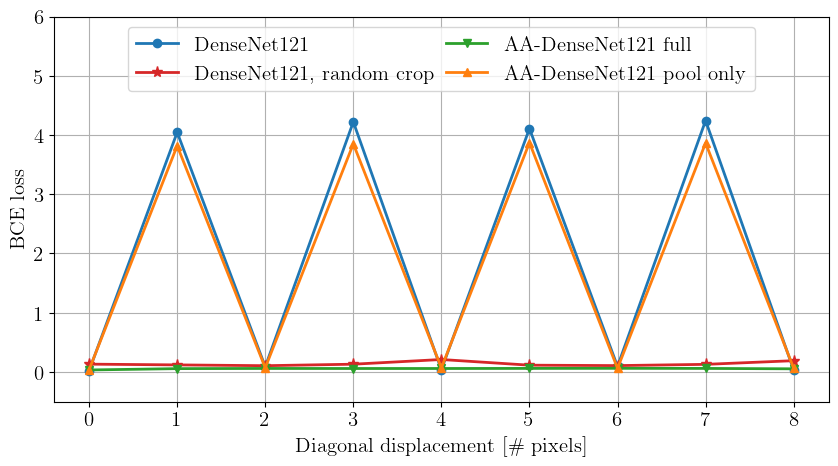

In [9]:
# Prepare plot
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
fontsize=20
markers = ['o', '*', 'v', '^']
color_map = {'DenseNet121': '#1f77b4', 'AA-DenseNet121 pool only': '#ff7f0e', 
              'AA-DenseNet121': '#2ca02c', 'DenseNet121 random crop': '#d62728'}
for idx, model_path in enumerate(models_paths):
    net_name = model_path.split('net-')[1].split('_')[0]
    random_crop = model_path.split('random_crop-')[1].split('/')[0] == 'True'
    aa_pool = model_path.split('aa_pool_only-')[1].split('/')[0] == 'True' if 'aa_pool' in model_path else ''
    if 'AA' in net_name:
        if aa_pool:
            label = f'AA-DenseNet121 pool only'
        else:
            label = f'AA-DenseNet121 full'
        color = color_map['AA-DenseNet121 pool only'] if aa_pool else color_map['AA-DenseNet121']
    else:
        label = f'{net_name}'
        if random_crop:
            label += ', random crop'
        color = color_map['DenseNet121 random crop'] if random_crop else color_map['DenseNet121']
    test_df = all_models_df.loc[(model_path)]
    mean_df = test_df.groupby('Grid displacement').mean()
    axs.plot(mean_df['bce_loss'], label=label, marker=markers[idx], markersize=8 if markers[idx] == '*' else 6, 
             linewidth=2, color=color)
axs.legend(fontsize=fontsize-5, ncol=2, columnspacing=0.5, loc='upper center')
axs.set_ylabel(r'BCE loss', fontsize=fontsize-5)
axs.tick_params('both', labelsize=fontsize-5)
axs.set_xlabel(r'Diagonal displacement [\# pixels]', fontsize=fontsize-5)
axs.grid('on')
axs.set_ylim([-0.5, 6])
axs.set_xticks(np.arange(9))
plt.show()

## Credits
[Image and Sound Processing Lab (ISPL)](http://ispl.deib.polimi.it/)
- Edoardo Daniele Cannas;
- Sara Mandelli;
- Paolo Bestagini;
- Stefano Tubaro.